In [4]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline
import time 
from ipywidgets import interact
from matplotlib import animation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.writer'] = 'avconv'
# workaround function for strange interact implementation
def showInInteract():
    import inspect
    for i in range(5):
        if 'interaction.py' in inspect.stack()[i][1]: plt.show()

# Quantizers and Quantization Noise 

A quantizer is a signal processing block, that maps a continuous amplitude to a discrete amplitude. The output of the quantizer is discrete, meaning that it can only output $Q$ different values. Practically, the quantizer is an analog-to-digital converter, since it maps the continuous input amplitude to a digital representation of this value. Formally, the quantized output $Q[x]$ of some input value $x$, is given by 

$$Q[x] = \arg \min_{l\in\mathcal{S}} |l-x|.$$

Here, the set $\mathcal{S}$ contains all possible output values of the quantizer, which we name *quantization levels*. What does that mean? It means, that for a given input $x$, the quantizer returns the *quantization level* $l$, which is closest to the input value. Hence, a quantizer is completely defined by its set of quantization levels $\mathcal{S}$. 

Let's assume the quantizer should be able to quantize values between the input amplitudes $-U$ and $+U$, i.e. the peak-to-peak amplitude range equals $2U$. Furthermore, the quantization levels should be encoded by $b$ bits. This gives us a number of $q=2^b$ different quantization levels in $\mathcal{S}$. Then, a logical decision is to make the distance $\Delta_s$ between the quantization levels constant, and equal to 

$$\Delta_s = \frac{2U}{q}.$$

Commonly, there are two different quantizers used, the *mid-rise* and the *mid-tread* quantizer. They differ in the setting of their levels: For the *mid-tread* we have $0\in\mathcal{S}$, whereas for the *mid-rise* quantizer we have $0\neq\mathcal{S}$, i.e. the mid-tread quantizer has a level for the zero output value. The quantization levels for both quantizers are defined by

$$\begin{align}
\mathcal{S} &= \{-U+\frac{\Delta_s}{2}+\Delta_s\cdot(0,1,2,\dots, q-1)\}&\text{ for mid-rise}\\
\mathcal{S} &= \{-U+\Delta_s\cdot(0,1,2,\dots, q-1)\}&\text{ for mid-tread}
\end{align}$$



Let us define some values for a demonstration of the quantizers:

In [40]:
b = 4           # number of bits for quantization. 
q = 2**b         # 2 bits equal 4 quantization levels
U = 1            # max. Amplitude to be quantized
Delta_s = 2*U/q  # level distance

S_midrise = -U + Delta_s/2 + np.arange(q)*Delta_s
S_midtread = -U  + np.arange(q)*Delta_s

Further, let's define a function `quantize` that performs the quantization operation 
$$x_q(x) = \arg \min_{l\in\mathcal{S}} |l-x|^2.$$

In [41]:
def quantize(x, S):
    X = x.reshape((-1,1))
    S = S.reshape((1,-1))
    dists = abs(X-S)
    
    nearestIndex = dists.argmin(axis=1)
    quantized = S.flat[nearestIndex]
    
    return quantized.reshape(x.shape)

def quantize2(x, U, b):
    if U is None:
        U = 2**b/(2**b-2)*np.max(np.abs(x))
        # add one more quantization level
        # avoids clipping up to 55 bit
        #U += 3 * U / 2**b
    Delta_s = 2*U/2**b
    # symmetric quantization does not include 0, so we have to 
    # add Delta_s / 2 before quantization, and substract it afterwards
    # division by Delta_s maps to the range [-2**b, 2**b], 
    # which is subsequently rounded to integers
    # original signal range is restored by multiplication with Delta_s 
    X = np.rint((x + Delta_s/2)/Delta_s)*Delta_s - Delta_s/2
    # apply clipping of excess values
    print(X[X<-U + Delta_s/2].any())
    print(X[X>U - Delta_s/2].any())
    X[X<=-U + Delta_s/2] =- U + Delta_s/2
    X[X>=U - Delta_s/2]  =  U - Delta_s/2
    return X
    


Let us draw the quantization curve of both quantizers to show their difference. The quantization curve is a diagram that shows the output of the quantizer for a range of inputs:

True
False


0.0

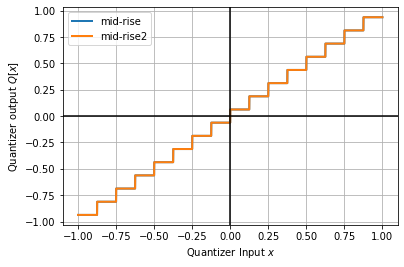

In [47]:

In = np.linspace(-1*U, 1*U, 20000)

Out_midrise = quantize(In, S_midrise)
#Out_midtread = quantize(In, S_midtread)
plt.plot(In, Out_midrise, lw=2, label='mid-rise')
#plt.plot(In, Out_midtread, lw=2, label='mid-tread')
#print(Out_midrise)
Out_midrise2 = quantize2(In, U, b)
#Out_midtread = quantize2(In, U, b)
#print(Out_midrise)
plt.plot(In, Out_midrise2, lw=2, label='mid-rise2')
#plt.plot(In, Out_midtread, lw=2, label='mid-tread2')
plt.axvline(0, color='k'); plt.axhline(0, color='k'); plt.legend(fontsize=10)
plt.grid(True);  plt.xlabel('Quantizer Input $x$'); plt.ylabel('Quantizer output $Q[x]$');
np.var(Out_midrise-Out_midrise2)

As we can see, the mid-rise quantizer creates a symmetric distribution of quantization levels, whereas the mid-tread quantizer has more levels below zero than above zero. Note that since $2^b=q$ is an even number, the mid-tread quantizer cannot be symmetric in any case. In the following, we will focus on the mid-rise quantizer.

## Quantization Noise

The quantization operation introduces an error, because the infinite amount of different input amplitudes is mapped to a finite set of discrete quantization levels. The error between the quantizer's input and output is termed *Quantization noise* $n_q(t)$. When denoting with $s(t)$ the input signal and $s_q(t)$ the output signal of the quantizer, the following relation holds:

$$\begin{align}
s_q(t)&=Q[s(t)]&&\text{Quantization operation}\\
n_q(t)&=s(t)-s_q(t)&&\text{Expression of quantization noise}\\
s_q(t)&=s(t)-n_q(t)
\end{align}.$$

Looking at the last equation, the quantization noise can indeed be understood as a noise on top of the continuous-amplitude signal, hence its name. Let us create a sine wave and sent it through the quantizer and let's look at the quantized signal and the quantization noise.

First, we define a convinience function `calcLevels` which calculates the quantization levels for a given bit count b.

In [5]:
def calcLevels(U, b, quantization_type):
    N_levels = 2**b
    delta = 2*U / N_levels
    
    if quantization_type == 'mid-rise':
        levels = -U + delta/2 + np.arange(N_levels) * delta 
    elif quantization_type == 'mid-tread':
        levels = -U + np.arange(N_levels) * delta
    else:
        raise RuntimeError("Unknown quantization type!")
    
    return levels

Now, let's generate a sine signal and show the resulting quantization noise.

In [18]:
Fs = 100  # the sampling frequency
f = 1     # frequency of the sine wave
T = 3000     # time duration to look at
t = np.arange(0, T, 1/Fs)
s = np.sin(2*np.pi*f*t)
def showQuantizationNoise(b):
    plt.gcf().clear()
    S = calcLevels(U, b, 'mid-rise')
    s_q = quantize(s, S)
    n_q = s - s_q

    plt.plot(t, s, label='$s(t)$')
    plt.plot(t, s_q, lw=2, label='$s_q(t)$')
    plt.plot(t, n_q, label='$n_q(t)$');
    plt.text(0.25, -0.5, 'b=%d' % b, ha='center', bbox=dict(facecolor='white'))
    plt.legend(fontsize=10); plt.xlabel('$t$'); plt.grid(); plt.axhline(0, color='k');
    showInInteract()

In [19]:
interact(showQuantizationNoise, b=(1,16));

interactive(children=(IntSlider(value=8, description='b', max=16, min=1), Output()), _dom_classes=('widget-int…

As you see, with increasing number of quantization bits, the quantization error almost vanishes. However, an important measure is the signal-to-quantization noise ratio (SNR), and we are going to measure it. With high enough bit counts, the quantization noise is approximately uniformly distributed within $\pm\frac{\Delta_s}{2}$. In literature, e.g. [Proakis: Digital Signal Processing](https://www.amazon.de/Digital-Signal-Processing-John-Proakis/dp/1292025735/), it has been shown that the quantization SNR for a sine-wave with full excitation (i.e. the sine amplitude equals the quantization range) can be given by 

$$SNR\approx (1.76 + 6.02b)dB,$$

with $b$ being the number of bits for the quantization. 

Let us write a function to measure this quantization noise. Here, we directly [convert the SNR to dB scale](http://dspillustrations.com/pages/posts/misc/decibel-conversion-factor-10-or-factor-20.html ).

In [20]:
def calcQuantizationNoise(signal, b):
    S = calcLevels(U, b, 'mid-rise')
    signal_q = quantize(signal, S)
    n_q = signal - signal_q
    
    P_S = (signal**2).sum()
    P_N = (n_q**2).sum()
    
    SNR = 10*np.log10(P_S/P_N)  # use 
    return SNR

We can now plot the quantization noise against the number of bits and compare it against the theoretical curve of $1.76+6.02b$.

In [21]:
bits = np.arange(1, 17)
SNR = [calcQuantizationNoise(np.sin(2*np.pi*t*f), b) for b in bits]
plt.plot(bits, SNR, 'o', label='SNR measured')
plt.plot(bits, 1.76+6.02*bits, 'k--', lw=2, label='$1.76+6.02b$')
plt.grid(True); plt.xlabel('$b$'); plt.ylabel('Quantization SNR');

MemoryError: Unable to allocate 73.2 GiB for an array with shape (300000, 32768) and data type float64

As we see, the approximation holds very well. Let us now look at what happens when we decrease the amplitude of the sine:

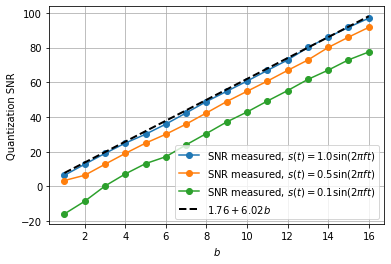

In [10]:
for A in [1, 0.5, 0.1]:
    SNR = [calcQuantizationNoise(A*np.sin(2*np.pi*t*f), b) for b in bits]
    plt.plot(bits, SNR, 'o-', label=r'SNR measured, $s(t)=%.1f \sin(2\pi ft)$' % A)

plt.plot(bits, 1.76+6.02*bits, 'k--', lw=2,label='$1.76+6.02b$')
plt.legend(fontsize=10, loc='lower right')
plt.grid(True); plt.xlabel('$b$'); plt.ylabel('Quantization SNR');

As we see, the quantization SNR degrades when the sine amplitude decreases. This is reasonable, since the quantization noise only depends on the number of quantization bits $b$, and is hence independent of the signal amplitude and so is the quantization noise power. On the other hand, the signal power decreases, when the amplitude decreases. Hence, we see a SNR degradation. However, the important notice is that the improvement in SNR for each additional bit remains to be $6$dB, independent of the signal amplitude.

Let us now measure the quantization SNR for a signal that is just Gaussian noise:

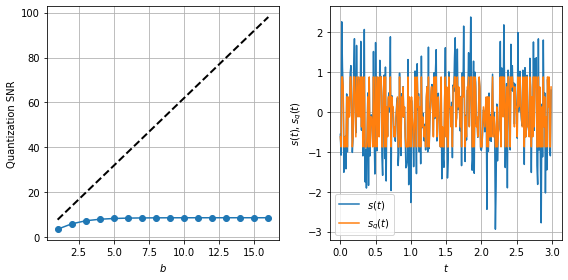

In [11]:
signal = np.random.randn(len(t))  # generate some random signal

plt.figure(figsize=(8,4))
plt.subplot(121)
SNR_noise = [calcQuantizationNoise(signal, b) for b in bits]
plt.plot(bits, SNR_noise, 'o-', label=r'SNR measured, $s(t)=%.1f \sin(2\pi ft)$' % A)
plt.plot(bits, 1.76+6.02*bits, 'k--', lw=2,label='$1.76+6.02b$')
plt.grid(True); plt.xlabel('$b$'); plt.ylabel('Quantization SNR');

plt.subplot(122)
signal_q = quantize(signal, calcLevels(U, 3, 'mid-rise'))
plt.plot(t, signal, label='$s(t)$')
plt.plot(t, signal_q, label='$s_q(t)$')
plt.grid(True); plt.ylabel('$s(t), s_q(t)$'); plt.xlabel('$t$');
plt.legend(fontsize=10);
plt.tight_layout();

What's going on here? The quantization SNR is pretty low despite 14 bits resolution? Looking at the original and quantized signal reveals the problem: The quantizer is simply in overdrive: The input signal is higher than the quantizer can output. So, it can never reach a good quantization. Let us eventually reduce the noise amplitude and see if this helps:

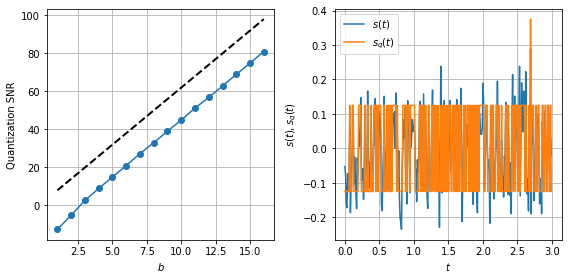

In [17]:
signal = 0.1 * np.random.randn(len(t))

plt.figure(figsize=(8,4))
plt.subplot(121)
SNR_noise = [calcQuantizationNoise(signal, b) for b in bits]
plt.plot(bits, SNR_noise, 'o-', label=r'SNR measured, $s(t)=%.1f \sin(2\pi ft)$' % A)
plt.plot(bits, 1.76+6.02*bits, 'k--', lw=2,label='$1.76+6.02b$')
plt.grid(True); plt.xlabel('$b$'); plt.ylabel('Quantization SNR');


plt.subplot(122)
signal_q = quantize(signal, calcLevels(U, 3, 'mid-rise'))
plt.plot(t, signal, label='$s(t)$')
plt.plot(t, signal_q, label='$s_q(t)$')
plt.grid(True); plt.ylabel('$s(t), s_q(t)$'); plt.xlabel('$t$');
plt.legend(fontsize=10);
#plt.xlim((0,0.3))
plt.tight_layout();

Now we see that the quantization SNR increases with 6dB for each bit. But, looking at the signals, we see another important thing: Even though the quantizer would be able to output values between $\pm 1$, most of its values are concentrated with in $\pm 0.1$. This is due to the character of the Gaussian noise signal which concentrates mostly around $s(t)=0$. Hence, to improve the SNR it would make sense to increase the resolution in the lower quantization levels at the cost of a coarser discretization in the higher amplitudes. This technique is known as non-linear quantizers but is out of scope here.

## Summary
> - A quantizer maps a continuous analog amplitude to a discrete amplitude level. 
> - A quantizer introduces quantization noise, which can indeed be treated as extra noise in the system, as long as the quantizer resolution is high enough.
> - The quantization noise reduces by $6$dB for each additional quantization bit. This number is independent of the quantization excitation or signal type.